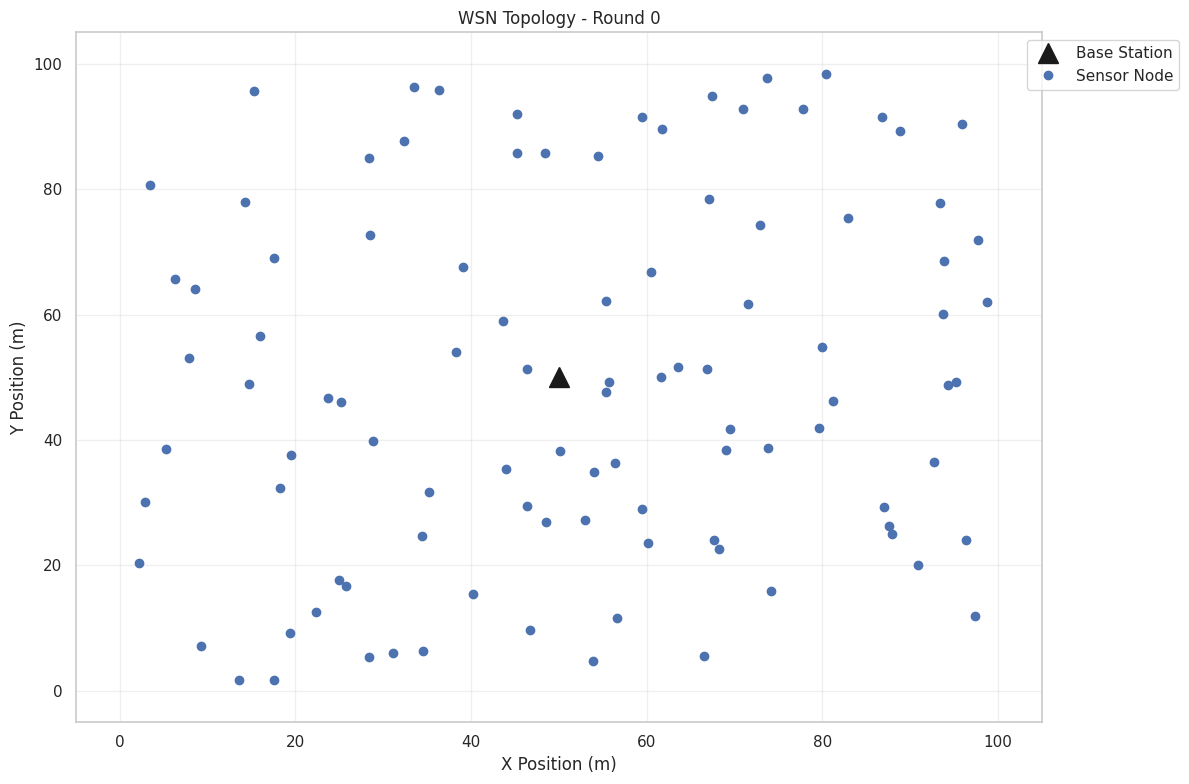

100%|██████████| 2000/2000 [01:18<00:00, 25.39it/s]


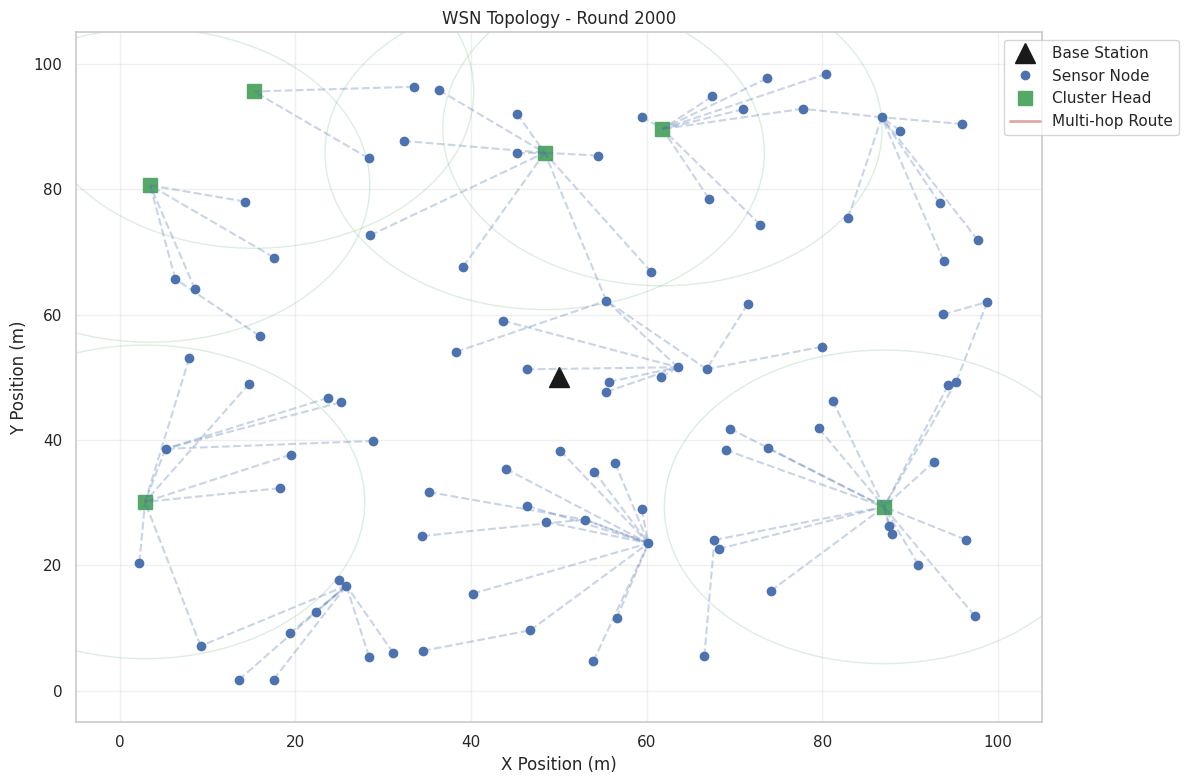

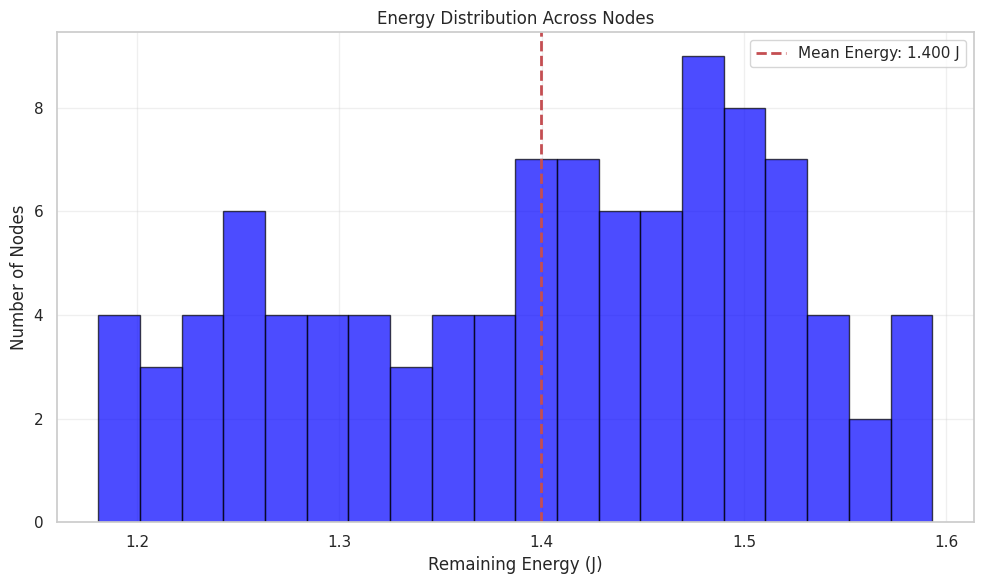

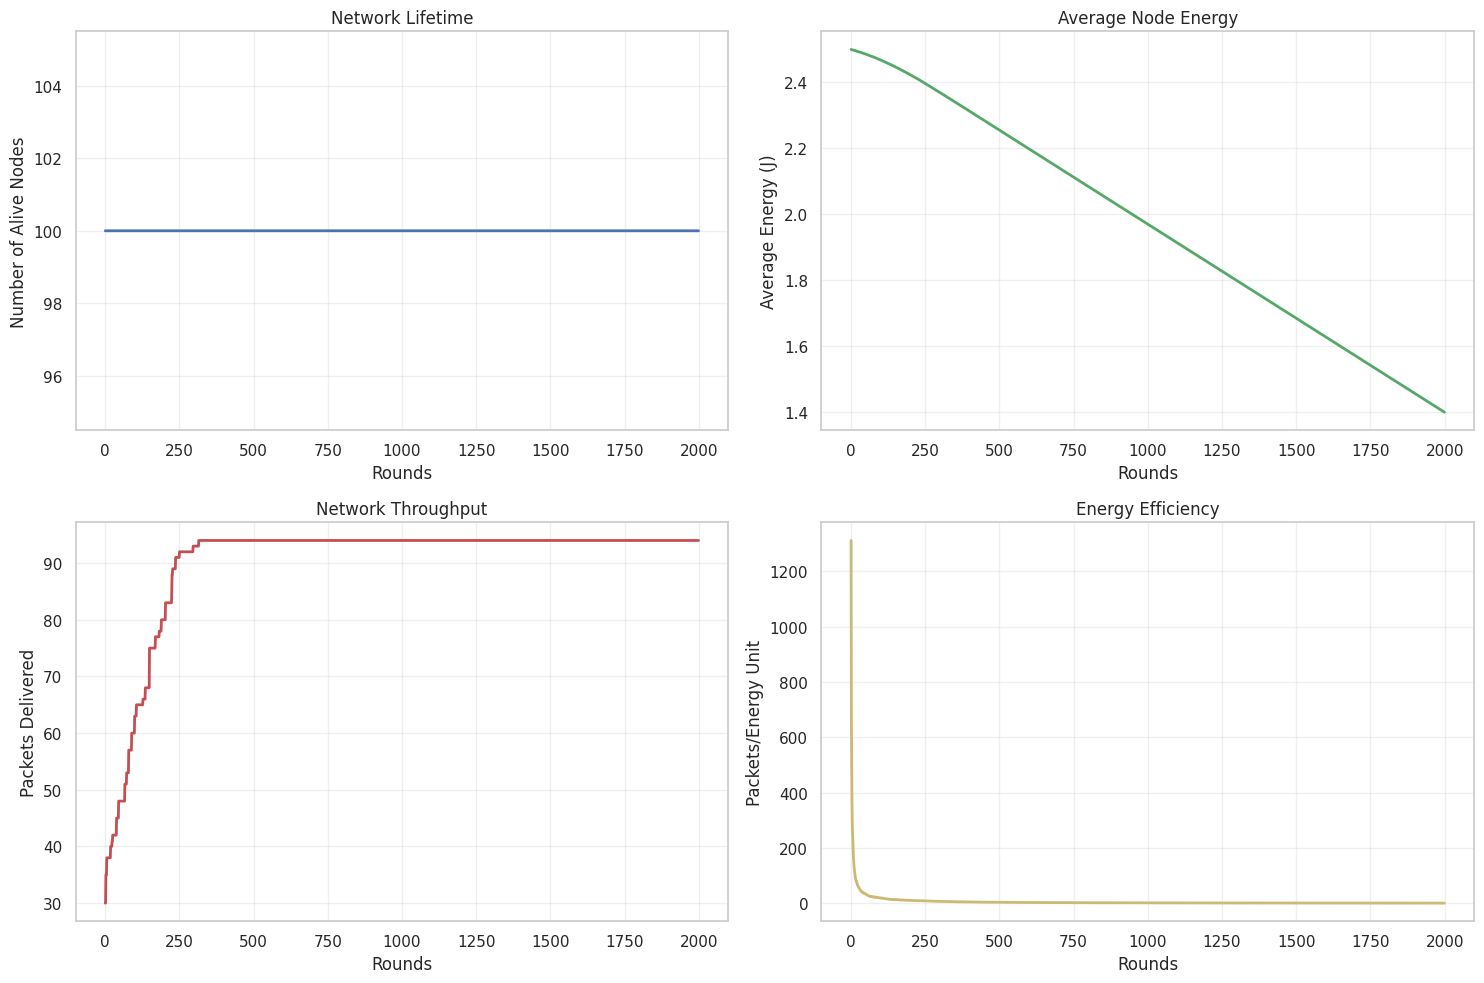

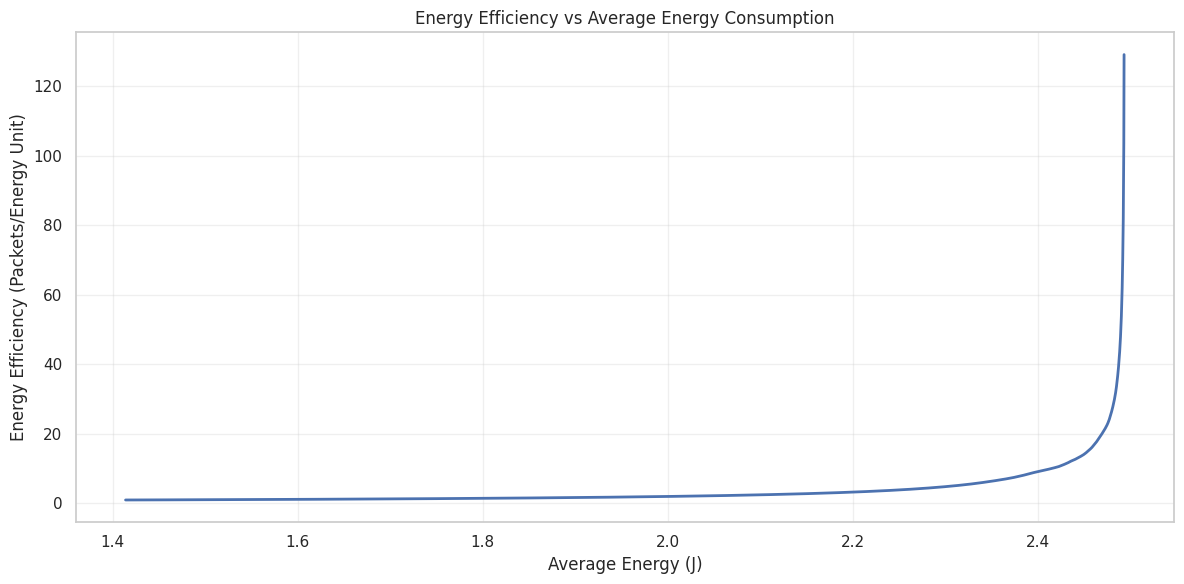


=== WSN Simulation Summary ===
Network Lifetime: 2000 rounds
First Node Death: Round 0
Total Packets Delivered: 180,578
Average Energy Efficiency: 6.7178 packets/energy unit
Final Alive Nodes: 100
Average Network Lifetime: 100.0%


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import seaborn as sns
from typing import List, Tuple, Dict, Optional
import networkx as nx
from dataclasses import dataclass
import random
from collections import defaultdict
import time
import json
from tqdm import tqdm
import logging
import asyncio
from functools import lru_cache
import pytest
from concurrent.futures import ThreadPoolExecutor
import nest_asyncio

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Custom exception class
class WSNException(Exception):
    """Custom exception for WSN-related errors"""
    pass

class NodeConfig:
   INITIAL_ENERGY: float = 2.5
   TRANSMIT_ENERGY: float = 20e-8
   RECEIVE_ENERGY: float = 20e-8
   AMPLIFIER_ENERGY: float = 4e-11
   DATA_PACKET_SIZE: int = 1000
   CONTROL_PACKET_SIZE: int = 100
   TRANSMISSION_RANGE: float = 25
   ENERGY_THRESHOLD: float = 0.3
   PROCESSING_POWER: float = 0.00005

@dataclass
class NetworkConfig:
   NETWORK_SIZE: Tuple[int, int] = (100, 100)
   NUM_NODES: int = 100
   BASE_STATION_POS: Tuple[float, float] = (50.0, 50.0)
   MAX_ROUNDS: int = 2000
   OPTIMAL_CLUSTERS: int = 6
   MAX_HOPS: int = 3


@dataclass
class LearningConfig:
    """Configuration parameters for reinforcement learning"""
    LEARNING_RATE: float = 0.1
    DISCOUNT_FACTOR: float = 0.9
    EXPLORATION_RATE: float = 0.1
    MIN_EXPLORATION_RATE: float = 0.01
    EXPLORATION_DECAY: float = 0.995

class SensorNode:
    """Represents a single sensor node in the WSN"""

    def __init__(self, node_id: int, position: Tuple[float, float], config: NodeConfig):
        self.id = node_id
        self.position = position
        self.config = config
        self.energy = config.INITIAL_ENERGY
        self.cluster_head = None
        self.is_cluster_head = False
        self.cluster_members = []
        self.q_table = {}
        self.state_history = []
        self.reward_history = []

    def validate_energy(self):
        """Validate node energy levels"""
        if self.energy < 0:
            raise WSNException(f"Node {self.id} has negative energy")
        if self.energy > self.config.INITIAL_ENERGY:
            raise WSNException(f"Node {self.id} has energy exceeding initial value")

    def calculate_distance(self, other_position: Tuple[float, float]) -> float:
        """Calculate Euclidean distance to another position"""
        return np.sqrt(
            (self.position[0] - other_position[0])**2 +
            (self.position[1] - other_position[1])**2
        )

    def calculate_transmission_energy(self, distance: float, packet_size: int) -> float:
        """Calculate energy required for transmission"""
        if distance < self.config.TRANSMISSION_RANGE:
            return (self.config.TRANSMIT_ENERGY +
                   self.config.AMPLIFIER_ENERGY * distance**2) * packet_size
        return (self.config.TRANSMIT_ENERGY +
               self.config.AMPLIFIER_ENERGY * distance**4) * packet_size

    def transmit_data(self, distance: float, packet_size: int) -> bool:
        """Attempt to transmit data and update energy levels"""
        required_energy = self.calculate_transmission_energy(distance, packet_size)
        if self.energy >= required_energy:
            self.energy -= required_energy
            return True
        return False

    def receive_data(self, packet_size: int) -> bool:
        """Receive data and update energy levels"""
        required_energy = self.config.RECEIVE_ENERGY * packet_size
        if self.energy >= required_energy:
            self.energy -= required_energy
            return True
        return False

    def is_alive(self) -> bool:
        """Check if node has enough energy to operate"""
        return self.energy > self.config.ENERGY_THRESHOLD

class WSNOptimizer:
    """Main class for WSN optimization using ML-based clustering and multi-hop routing"""

    def __init__(self, network_config: NetworkConfig, node_config: NodeConfig,
                 learning_config: LearningConfig):
        self.network_config = network_config
        self.node_config = node_config
        self.learning_config = learning_config
        self.validate_config()
        self.nodes: List[SensorNode] = []
        self.cluster_heads: List[SensorNode] = []
        self.routes: Dict = {}
        self.performance_metrics = {
            'rounds': [],
            'alive_nodes': [],
            'average_energy': [],
            'packets_delivered': [],
            'network_lifetime': 0,
            'first_node_death': 0,
            'energy_efficiency': []
        }
        self.initialize_network()
        self.route_cache = {}
        self.executor = ThreadPoolExecutor(max_workers=4)

    def validate_config(self):
        """Validate configuration parameters"""
        if self.network_config.NUM_NODES < 1:
            raise WSNException("Invalid number of nodes")
        if self.network_config.OPTIMAL_CLUSTERS >= self.network_config.NUM_NODES:
            raise WSNException("Too many clusters for given nodes")

    def initialize_network(self):
        """Initialize sensor nodes in the network"""
        for i in range(self.network_config.NUM_NODES):
            position = (
                random.uniform(0, self.network_config.NETWORK_SIZE[0]),
                random.uniform(0, self.network_config.NETWORK_SIZE[1])
            )
            node = SensorNode(i, position, self.node_config)
            self.nodes.append(node)

    def get_node_features(self, node: SensorNode) -> np.ndarray:
        """Extract features for ML-based cluster head selection"""
        # Energy ratio
        energy_ratio = node.energy / self.node_config.INITIAL_ENERGY

        # Node density
        neighbors = self.get_neighbors(node)
        density = len(neighbors) / self.network_config.NUM_NODES

        # Distance to base station
        distance_to_bs = node.calculate_distance(self.network_config.BASE_STATION_POS)
        max_distance = np.sqrt(sum(x**2 for x in self.network_config.NETWORK_SIZE))
        normalized_distance = distance_to_bs / max_distance

        return np.array([energy_ratio, density, normalized_distance])

    def get_neighbors(self, node: SensorNode) -> List[SensorNode]:
        """Get neighboring nodes within transmission range"""
        return [
            n for n in self.nodes
            if n.id != node.id and
            node.calculate_distance(n.position) <= self.node_config.TRANSMISSION_RANGE
        ]

    def select_cluster_heads(self) -> List[SensorNode]:
        """Select cluster heads using reinforcement learning"""
        candidates = []
        rewards = []

        for node in self.nodes:
            if not node.is_alive():
                continue

            features = self.get_node_features(node)
            state = tuple(np.round(features, 3))

            if state not in node.q_table:
                node.q_table[state] = np.random.uniform(0, 1)

            # Epsilon-greedy exploration
            if random.random() < self.learning_config.EXPLORATION_RATE:
                action = random.choice([True, False])
            else:
                action = node.q_table[state] > np.mean([n.q_table.get(state, 0)
                                                      for n in self.nodes if n.is_alive()])

            if action:
                reward = self.calculate_ch_reward(node, features)
                # Update Q-value
                node.q_table[state] = (1 - self.learning_config.LEARNING_RATE) * \
                    node.q_table[state] + self.learning_config.LEARNING_RATE * reward

                candidates.append((node, reward))
                rewards.append(reward)

        # Select top cluster heads based on rewards
        candidates.sort(key=lambda x: x[1], reverse=True)
        selected_ch = [c[0] for c in candidates[:self.network_config.OPTIMAL_CLUSTERS]]

        # Update cluster head status
        for node in self.nodes:
            node.is_cluster_head = node in selected_ch
            node.cluster_members = []

        return selected_ch

    def calculate_ch_reward(self, node: SensorNode, features: np.ndarray) -> float:
        energy_weight = 0.6
        density_weight = 0.25
        distance_weight = 0.15

        energy_score = features[0]
        density_score = features[1]
        distance_score = 1 - features[2]

        if energy_score < 0.4:
           energy_score *= 0.5

        return (energy_weight * energy_score +
               density_weight * density_score +
               distance_weight * distance_score)

    def consume_processing_energy(self, node: SensorNode):
       processing_energy = node.config.PROCESSING_POWER
       if node.is_cluster_head:
           processing_energy *= 2
       if node.energy > processing_energy:
          node.energy -= processing_energy

    def form_clusters(self):
        """Assign nodes to nearest cluster head"""
        for node in self.nodes:
            if not node.is_alive() or node.is_cluster_head:
                continue

            # Find nearest cluster head
            min_dist = float('inf')
            nearest_ch = None

            for ch in self.cluster_heads:
                if not ch.is_alive():
                    continue

                dist = node.calculate_distance(ch.position)
                if dist < min_dist and dist <= self.node_config.TRANSMISSION_RANGE:
                    min_dist = dist
                    nearest_ch = ch

            if nearest_ch:
                node.cluster_head = nearest_ch
                nearest_ch.cluster_members.append(node)

    def establish_multi_hop_routes(self):
        """Establish multi-hop routes from cluster heads to base station"""
        self.routes = {}
        for ch in self.cluster_heads:
            if not ch.is_alive():
                continue

            route = self.find_optimal_route(ch)
            if route:
                self.routes[ch.id] = route

    @lru_cache(maxsize=1000)
    def find_optimal_route(self, source: SensorNode) -> List[SensorNode]:
        """Find optimal route using modified Dijkstra's algorithm"""
        distances = {node.id: float('inf') for node in self.nodes}
        distances[source.id] = 0
        previous = {node.id: None for node in self.nodes}
        unvisited = set(node.id for node in self.nodes if node.is_alive())

        while unvisited:
            current = min(unvisited, key=lambda x: distances[x])
            if distances[current] == float('inf'):
                break

            unvisited.remove(current)
            current_node = next(n for n in self.nodes if n.id == current)

            for neighbor in self.get_neighbors(current_node):
                if not neighbor.is_alive() or neighbor.id not in unvisited:
                    continue

                distance = current_node.calculate_distance(neighbor.position)
                energy_cost = current_node.calculate_transmission_energy(
                    distance, self.node_config.DATA_PACKET_SIZE)

                new_distance = distances[current] + energy_cost
                if new_distance < distances[neighbor.id]:
                    distances[neighbor.id] = new_distance
                    previous[neighbor.id] = current

        # Reconstruct path
        path = []
        current = min(distances, key=lambda x: distances[x])
        while current is not None:
            path.append(next(n for n in self.nodes if n.id == current))
            current = previous[current]

        return path[::-1] if path else None

    async def simulate_round(self) -> Tuple[int, float, int]:
       """Asynchronous simulation of one network round"""
       try:
           logger.info(f"Starting round {len(self.performance_metrics['rounds']) + 1}")

           # Parallel cluster head selection and setup
           self.cluster_heads = await asyncio.get_event_loop().run_in_executor(
               self.executor, self.select_cluster_heads
           )
           for node in self.nodes:
               self.consume_processing_energy(node)

           # Parallel cluster formation
           await asyncio.get_event_loop().run_in_executor(self.executor, self.form_clusters)
           for node in self.nodes:
               if node.is_cluster_head:
                   self.consume_processing_energy(node)

           # Parallel route establishment
           await asyncio.get_event_loop().run_in_executor(
               self.executor, self.establish_multi_hop_routes
           )

           packets_delivered = 0

           # Parallel intra-cluster communication
           async def process_node(node):
               if not node.is_alive() or node.is_cluster_head:
                   return 0

               if node.cluster_head and node.cluster_head.is_alive():
                   distance = node.calculate_distance(node.cluster_head.position)
                   if node.transmit_data(distance, self.node_config.DATA_PACKET_SIZE):
                       self.consume_processing_energy(node)
                       if node.cluster_head.receive_data(self.node_config.DATA_PACKET_SIZE):
                           self.consume_processing_energy(node.cluster_head)
                           return 1
               return 0

           tasks = [process_node(node) for node in self.nodes]
           results = await asyncio.gather(*tasks)
           packets_delivered += sum(results)

           # Parallel inter-cluster communication
           async def process_cluster_head(ch):
               if not ch.is_alive() or ch.id not in self.routes:
                   return 0

               route = self.routes[ch.id]
               aggregated_data_size = self.node_config.DATA_PACKET_SIZE * (len(ch.cluster_members) + 1)

               aggregation_energy = 5e-9 * aggregated_data_size
               if ch.energy <= aggregation_energy:
                   return 0
               ch.energy -= aggregation_energy

               delivered = 0
               for i in range(len(route) - 1):
                   current, next_node = route[i], route[i + 1]
                   if not current.is_alive() or not next_node.is_alive():
                       break

                   distance = current.calculate_distance(next_node.position)
                   if current.transmit_data(distance, aggregated_data_size):
                       self.consume_processing_energy(current)
                       if next_node.receive_data(aggregated_data_size):
                           self.consume_processing_energy(next_node)
                           if i == len(route) - 2:
                               delivered = len(ch.cluster_members) + 1
                       else:
                           break
                   else:
                       break
               return delivered

           ch_tasks = [process_cluster_head(ch) for ch in self.cluster_heads]
           ch_results = await asyncio.gather(*ch_tasks)
           packets_delivered += sum(ch_results)

           alive_nodes = sum(1 for node in self.nodes if node.is_alive())
           avg_energy = np.mean([node.energy for node in self.nodes])

           return alive_nodes, avg_energy, packets_delivered

       except Exception as e:
           logger.error(f"Round simulation failed: {str(e)}")
           raise

    async def run_simulation(self):
        self.performance_metrics = {
            'rounds': [],
            'alive_nodes': [],
            'average_energy': [],
            'packets_delivered': [],
            'network_lifetime': 0,
            'first_node_death': 0,
            'energy_efficiency': []
        }

        first_node_death = 0

        try:
            for round_number in tqdm(range(self.network_config.MAX_ROUNDS)):
                alive_nodes, avg_energy, packets = await self.simulate_round()

                self.learning_config.EXPLORATION_RATE = max(
                    self.learning_config.MIN_EXPLORATION_RATE,
                    self.learning_config.EXPLORATION_RATE * self.learning_config.EXPLORATION_DECAY
                )

                self.performance_metrics['rounds'].append(round_number)
                self.performance_metrics['alive_nodes'].append(alive_nodes)
                self.performance_metrics['average_energy'].append(avg_energy)
                self.performance_metrics['packets_delivered'].append(packets)

                total_energy_consumed = sum(
                    self.node_config.INITIAL_ENERGY - node.energy
                    for node in self.nodes
                )
                energy_efficiency = packets / total_energy_consumed if total_energy_consumed > 0 else 0
                self.performance_metrics['energy_efficiency'].append(energy_efficiency)

                if alive_nodes < self.network_config.NUM_NODES and first_node_death == 0:
                    first_node_death = round_number
                    self.performance_metrics['first_node_death'] = first_node_death

                if alive_nodes == 0:
                    break

        except Exception as e:
            logger.error(f"Error in simulation: {e}")

        self.performance_metrics['network_lifetime'] = len(self.performance_metrics['rounds'])
        return self.performance_metrics


    def calculate_network_metrics(self) -> Dict:
        total_packets = sum(self.performance_metrics['packets_delivered'])
        rounds = len(self.performance_metrics['rounds'])
        total_energy = sum(self.node_config.INITIAL_ENERGY - node.energy for node in self.nodes)

        return {
            'latency': self.calculate_average_latency(),
            'throughput': total_packets / rounds if rounds > 0 else 0,
            'packet_loss': self.calculate_packet_loss_rate(),
            'energy_distribution': self.get_energy_distribution(),
            'network_efficiency': total_packets / total_energy if total_energy > 0 else 0
        }

    def calculate_packet_loss_rate(self) -> float:
        total_sent = sum(len(ch.cluster_members) for ch in self.cluster_heads)
        total_received = sum(self.performance_metrics['packets_delivered'])
        return 1 - (total_received / total_sent) if total_sent > 0 else 0

    def calculate_average_latency(self) -> float:
        routes = [len(route) for route in self.routes.values() if route]
        return np.mean(routes) if routes else 0

    def calculate_packet_loss_rate(self) -> float:
        """Calculate packet loss rate"""
        total_sent = sum(len(ch.cluster_members) for ch in self.cluster_heads)
        total_received = sum(self.performance_metrics['packets_delivered'])
        return 1 - (total_received / total_sent) if total_sent > 0 else 0

    def get_energy_distribution(self) -> Dict:
        """Get energy distribution statistics"""
        energies = [node.energy for node in self.nodes]
        return {
            'mean': np.mean(energies),
            'std': np.std(energies),
            'min': min(energies),
            'max': max(energies)
        }


class WSNVisualizer:
    def __init__(self, optimizer: WSNOptimizer):
        self.optimizer = optimizer

    def visualize_network_topology(self, round_number: int):
        """Visualize current network state with clusters and routes"""
        plt.figure(figsize=(12, 8))
        plt.clf()  # Clear the current figure

        # Plot base station
        plt.plot(self.optimizer.network_config.BASE_STATION_POS[0],
                self.optimizer.network_config.BASE_STATION_POS[1],
                'k^', markersize=15, label='Base Station')

        # Plot nodes and connections
        cluster_heads_plotted = False
        sensor_nodes_plotted = False

        for node in self.optimizer.nodes:
            if not node.is_alive():
                plt.plot(node.position[0], node.position[1], 'rx',
                        markersize=8, alpha=0.5, label='Dead Node' if not cluster_heads_plotted else "")
                continue

            if node.is_cluster_head:
                plt.plot(node.position[0], node.position[1], 'gs',
                        markersize=10, label='Cluster Head' if not cluster_heads_plotted else "")
                cluster_heads_plotted = True

                # Draw cluster radius
                circle = plt.Circle(node.position, self.optimizer.node_config.TRANSMISSION_RANGE,
                                 color='g', fill=False, alpha=0.2)
                plt.gca().add_patch(circle)
            else:
                plt.plot(node.position[0], node.position[1], 'bo',
                        markersize=6, label='Sensor Node' if not sensor_nodes_plotted else "")
                sensor_nodes_plotted = True

                if node.cluster_head:
                    plt.plot([node.position[0], node.cluster_head.position[0]],
                           [node.position[1], node.cluster_head.position[1]],
                           'b--', alpha=0.3)

        # Plot multi-hop routes
        for ch_id, route in self.optimizer.routes.items():
            if not route:
                continue
            route_x = [node.position[0] for node in route]
            route_y = [node.position[1] for node in route]
            plt.plot(route_x, route_y, 'r-', linewidth=2, alpha=0.5,
                    label='Multi-hop Route' if ch_id == list(self.optimizer.routes.keys())[0] else "")

        plt.title(f'WSN Topology - Round {round_number}')
        plt.xlabel('X Position (m)')
        plt.ylabel('Y Position (m)')
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

        # Set axis limits
        plt.xlim(-5, self.optimizer.network_config.NETWORK_SIZE[0] + 5)
        plt.ylim(-5, self.optimizer.network_config.NETWORK_SIZE[1] + 5)

        plt.tight_layout()
        plt.show()

    def visualize_energy_distribution(self):
        """Visualize current energy distribution across nodes"""
        plt.figure(figsize=(10, 6))
        plt.clf()

        energies = [node.energy for node in self.optimizer.nodes]
        plt.hist(energies, bins=20, edgecolor='black', color='blue', alpha=0.7)
        plt.axvline(np.mean(energies), color='r', linestyle='dashed', linewidth=2,
                   label=f'Mean Energy: {np.mean(energies):.3f} J')

        plt.title('Energy Distribution Across Nodes')
        plt.xlabel('Remaining Energy (J)')
        plt.ylabel('Number of Nodes')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_performance_metrics(self):
        """Plot various performance metrics"""
        metrics = self.optimizer.performance_metrics

        fig = plt.figure(figsize=(15, 10))
        plt.clf()

        # Plot alive nodes over time
        plt.subplot(2, 2, 1)
        plt.plot(metrics['rounds'], metrics['alive_nodes'], 'b-', linewidth=2)
        plt.title('Network Lifetime')
        plt.xlabel('Rounds')
        plt.ylabel('Number of Alive Nodes')
        plt.grid(True, alpha=0.3)

        # Plot average energy over time
        plt.subplot(2, 2, 2)
        plt.plot(metrics['rounds'], metrics['average_energy'], 'g-', linewidth=2)
        plt.title('Average Node Energy')
        plt.xlabel('Rounds')
        plt.ylabel('Average Energy (J)')
        plt.grid(True, alpha=0.3)

        # Plot packets delivered over time
        plt.subplot(2, 2, 3)
        plt.plot(metrics['rounds'], metrics['packets_delivered'], 'r-', linewidth=2)
        plt.title('Network Throughput')
        plt.xlabel('Rounds')
        plt.ylabel('Packets Delivered')
        plt.grid(True, alpha=0.3)

        # Plot energy efficiency over time
        plt.subplot(2, 2, 4)
        plt.plot(metrics['rounds'], metrics['energy_efficiency'], 'y-', linewidth=2)
        plt.title('Energy Efficiency')
        plt.xlabel('Rounds')
        plt.ylabel('Packets/Energy Unit')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Additional comparative plots
        self.plot_comparative_analysis()

    def plot_comparative_analysis(self):
        metrics = self.optimizer.performance_metrics

        # Check if we have enough data
        if len(metrics['average_energy']) < 50 or len(metrics['energy_efficiency']) < 50:
            logger.warning("Not enough data for moving average calculation")
            return

        window = 50
        energy_ma = np.convolve(metrics['average_energy'],
                               np.ones(window)/window, mode='valid')
        efficiency_ma = np.convolve(metrics['energy_efficiency'],
                                   np.ones(window)/window, mode='valid')

        plt.figure(figsize=(12, 6))
        plt.plot(energy_ma, efficiency_ma, 'b-', linewidth=2)
        plt.title('Energy Efficiency vs Average Energy Consumption')
        plt.xlabel('Average Energy (J)')
        plt.ylabel('Energy Efficiency (Packets/Energy Unit)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def display_summary_statistics(self):
        metrics = self.optimizer.performance_metrics
        try:
            alive_nodes = metrics['alive_nodes'][-1] if metrics['alive_nodes'] else 0
            print("\n=== WSN Simulation Summary ===")
            print(f"Network Lifetime: {len(metrics['rounds'])} rounds")
            print(f"First Node Death: Round {metrics['first_node_death']}")
            print(f"Total Packets Delivered: {sum(metrics['packets_delivered']):,}")
            print(f"Average Energy Efficiency: {np.mean(metrics['energy_efficiency'] or [0]):.4f} packets/energy unit")
            print(f"Final Alive Nodes: {alive_nodes}")
            if metrics['alive_nodes']:
                print(f"Average Network Lifetime: {np.mean(metrics['alive_nodes'])/self.optimizer.network_config.NUM_NODES*100:.1f}%")
            print("============================")
        except Exception as e:
            logger.error(f"Error displaying statistics: {e}")

# Test functions
def test_node_energy_consumption():
    node = SensorNode(1, (0,0), NodeConfig())
    initial_energy = node.energy
    node.transmit_data(10, 1000)
    assert node.energy < initial_energy

def test_cluster_head_selection():
    optimizer = WSNOptimizer(NetworkConfig(), NodeConfig(), LearningConfig())
    cluster_heads = optimizer.select_cluster_heads()
    assert len(cluster_heads) <= optimizer.network_config.OPTIMAL_CLUSTERS

def test_route_finding():
    optimizer = WSNOptimizer(NetworkConfig(), NodeConfig(), LearningConfig())
    source = optimizer.nodes[0]
    route = optimizer.find_optimal_route(source)
    if route:
        assert len(route) <= optimizer.network_config.MAX_HOPS

async def main():
   try:
       plt.style.use('default')
       sns.set_theme(style="whitegrid")

       node_config = NodeConfig()
       network_config = NetworkConfig()
       learning_config = LearningConfig()

       logger.info("Initializing WSN Optimizer...")
       optimizer = WSNOptimizer(network_config, node_config, learning_config)
       visualizer = WSNVisualizer(optimizer)

       logger.info("Displaying Initial Network State")
       visualizer.visualize_network_topology(0)

       logger.info("Running WSN Simulation...")
       await optimizer.run_simulation()

       logger.info("Generating Final Results")
       visualizer.visualize_network_topology(len(optimizer.performance_metrics['rounds']))
       visualizer.visualize_energy_distribution()
       visualizer.plot_performance_metrics()
       visualizer.display_summary_statistics()

       network_metrics = optimizer.calculate_network_metrics()
       logger.info("\nNetwork Performance Metrics:")
       for metric, value in network_metrics.items():
           logger.info(f"{metric}: {value}")

   except Exception as e:
       logger.error(f"Simulation failed: {str(e)}")
       raise

nest_asyncio.apply()

if __name__ == "__main__":
    loop = asyncio.get_event_loop()
    loop.run_until_complete(main())
